In [32]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1
from sklearn.metrics import accuracy_score, roc_curve, auc
from tqdm import tqdm

# Инфра

In [33]:
class LabeledImage:
    def __init__(self, image_path, image_label):
        self.path = image_path
        self.label = image_label


def parse_dataset(dataset_dir) -> list[LabeledImage]:
    """
    Парсит датасет со структурой ./dir/<person>/<image>.jpg
    """
    labeled_images = []
    dir_path = f"./{dataset_dir}"
    for person in os.listdir(dir_path):
        person_dir = os.path.join(dir_path, person)
        if os.path.isdir(person_dir):
            for img in os.listdir(person_dir):
                if img.lower().endswith(('.jpg', 'png', 'jpeg')):
                    path = os.path.join(person_dir, img)
                    labeled_images.append(LabeledImage(path, person))
    return labeled_images


def get_embedding(img_path, model, show=False):
    img = Image.open(img_path).convert('RGB')
    face = mtcnn(img)

    if face is None:
        print(f"Лицо не обнаружено. path = {img_path}")
        return None

    if show:
        # Переводим тензор в numpy и транспонируем под формат [H, W, C]
        face_np = face.permute(1, 2, 0).cpu().numpy()
        face_np = np.clip(face_np, 0, 1)  # на случай значений вне диапазона

        # Отображение
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(img)
        axs[0].set_title("Оригинал")
        axs[0].axis('off')

        axs[1].imshow(face_np)
        axs[1].set_title("Обработанное лицо")
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()

    with torch.no_grad():
        embedding = model(face.unsqueeze(0).to(device))
    return embedding.cpu().numpy()[0]


def get_emb_distance(emb1, emb2):
    return np.linalg.norm(emb1 - emb2)


def get_img_distance(img1_path, img2_path, model):
    emb1 = get_embedding(img1_path, model)
    emb2 = get_embedding(img2_path, model)
    return get_emb_distance(emb1, emb2)


def verify_face(face1_path, face2_path, model, threshold=1.0) -> bool:
    dist = get_img_distance(face1_path, face2_path, model)
    print(f"Distance: {dist:.4f}")
    if dist < threshold:
        return True
    else:
        return False

### Тестирование модели

In [34]:
def load_lfw():
    lfw_dir = 'dataset/lfw_funneled'
    pairs_file = 'dataset/pairsDevTest.txt'

    with open(pairs_file, 'r') as f:
        lines = f.readlines()[1:]

    pairs = []
    labels = []

    for line in lines:
        parts = line.strip().split()
        if len(parts) == 3:
            # positive pair: name, idx1, idx2
            name, idx1, idx2 = parts
            img1 = os.path.join(lfw_dir, name, f"{name}_{int(idx1):04d}.jpg")
            img2 = os.path.join(lfw_dir, name, f"{name}_{int(idx2):04d}.jpg")
            label = 1
        elif len(parts) == 4:
            # negative pair: name1, idx1, name2, idx2
            name1, idx1, name2, idx2 = parts
            img1 = os.path.join(lfw_dir, name1, f"{name1}_{int(idx1):04d}.jpg")
            img2 = os.path.join(lfw_dir, name2, f"{name2}_{int(idx2):04d}.jpg")
            label = 0
        else:
            print(f"Invalid line: {parts}")
            break

        if os.path.exists(img1) and os.path.exists(img2):
            pairs.append((img1, img2))
            labels.append(label)
        else:
            print(f"Invalid line: {parts}")
            break

    pair_labels = [(pairs[i], labels[i]) for i in range(len(pairs))]
    print(f"Загружено {len(pairs)} пар")
    return pair_labels

In [35]:
def lfw_test(pair_labels, model):
    distances_list, y_true = [], []
    for (img1, img2), label in tqdm(pair_labels, total=len(pair_labels)):
        e1 = get_embedding(img1, model)
        e2 = get_embedding(img2, model)

        if e1 is None or e2 is None:
            continue

        dist = get_emb_distance(e1, e2)
        distances_list.append(dist)
        y_true.append(label)

    distances = np.vstack(distances_list)
    y_true = np.array(y_true)

    # 4. Определяем оптимальный порог по ROC-кривой
    fpr, tpr, thresholds = roc_curve(y_true, -distances)
    # (отрицание, потому что более похожие — меньшее расстояние)
    roc_auc = auc(fpr, tpr)

    # Выбираем threshold, при котором tpr – (1 – fpr) максимально
    gmeans = np.sqrt(tpr * (1 - fpr))
    ix = np.argmax(gmeans)
    best_thresh = thresholds[ix]

    # 5. Оцениваем точность при этом пороге
    y_pred = (distances < -best_thresh).astype(int)
    acc = accuracy_score(y_true, y_pred)

    print(f"AUC = {roc_auc:.4f}")
    print(f"Optimal threshold = {-best_thresh :.4f}")
    print(f"Accuracy = {acc:.4f}")

# ResNet

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используем {device}")
mtcnn = MTCNN(image_size=160, margin=0, device=device)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

Используем cpu


In [37]:
pair_labels = load_lfw()
lfw_test(pair_labels, resnet)

Загружено 1000 пар


100%|██████████| 1000/1000 [02:42<00:00,  6.15it/s]

AUC = 0.9751
Optimal threshold = 1.0212
Accuracy = 0.9650


# Практическое применение

In [44]:
import itertools
from matplotlib import gridspec

# Путь к папке с изображениями
labeles_images = parse_dataset("test")

# Сравнение попарно
path_pairs = list(itertools.combinations([p.path for p in labeles_images], 2))

# Визуализация
for path1, path2 in path_pairs:
    match = verify_face(path1, path2, resnet)

    print(f"{os.path.basename(path1)} - {os.path.basename(path2)}: \t {"Один человек" if match else "Разные люди"}")

    # # Визуализация
    # fig = plt.figure(figsize=(8, 4))
    # gs = gridspec.GridSpec(1, 2)
    # 
    # img1 = Image.open(path1)
    # img2 = Image.open(path2)
    # 
    # ax1 = fig.add_subplot(gs[0])
    # ax1.imshow(img1)
    # ax1.set_title(os.path.basename(path1))
    # ax1.axis('off')
    # 
    # ax2 = fig.add_subplot(gs[1])
    # ax2.imshow(img2)
    # ax2.set_title(os.path.basename(path2))
    # ax2.axis('off')
    # 
    # plt.suptitle(f"Расстояние: {"Совпадение" if match else "Различие"}", fontsize=14)
    # plt.tight_layout()
    # plt.show()


Distance: 0.9870
Egor_Alexeev_1.png - Egor_Alexeev_2.jpg: 	 Один человек
Distance: 1.3135
Egor_Alexeev_1.png - Misha_Melnikov_1.jpg: 	 Разные люди
Distance: 1.3025
Egor_Alexeev_1.png - Misha_Melnikov_2.jpg: 	 Разные люди
Distance: 1.3042
Egor_Alexeev_2.jpg - Misha_Melnikov_1.jpg: 	 Разные люди
Distance: 1.3626
Egor_Alexeev_2.jpg - Misha_Melnikov_2.jpg: 	 Разные люди
Distance: 0.4906
Misha_Melnikov_1.jpg - Misha_Melnikov_2.jpg: 	 Один человек


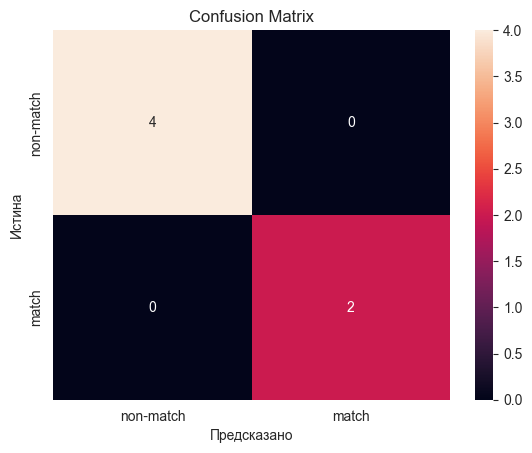

              precision    recall  f1-score   support

   non-match       1.00      1.00      1.00         4
       match       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6


In [41]:
import os, itertools
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

labeled_images = parse_dataset("test")

embeddings = np.stack([get_embedding(p.path, resnet) for p in labeled_images])
labels = np.array([p.label for p in labeled_images])

# Матрица попарных расстояний
N = len(labeled_images)
D = np.zeros((N, N))
for i, j in itertools.product(range(N), range(N)):
    D[i, j] = get_emb_distance(embeddings[i], embeddings[j])

threshold = 1

# Confusion Matrix для всех комбинаций
pairs = list(itertools.combinations(range(N), 2))
y_true, y_pred = [], []
for i, j in pairs:
    y_true.append(labels[i] == labels[j])
    y_pred.append(get_emb_distance(embeddings[i], embeddings[j]) < threshold)

cm = confusion_matrix(y_true, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['non-match', 'match'],
            yticklabels=['non-match', 'match'])
plt.xlabel('Предсказано')
plt.ylabel('Истина')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred,
                            target_names=['non-match', 'match']))